In [50]:
from fastai.vision.all import *
import pickle
from importlib import reload

import const
const = reload(const)
import train_class
train_class = reload(train_class)

# For vastai, we'll get data from root
const.SUBDIR_DATA_CLASS = "./"
# We'll dump models and preds into class/ and neg/
if not Path('class').exists(): Path('class').mkdir()
if not Path('neg').exists(): Path('neg').mkdir()
const.SUBDIR_MODELS_CLASS = "class/"
const.SUBDIR_PREDS_CLASS = "class/"
const.SUBDIR_MODELS_NEG = "neg/"
const.SUBDIR_PREDS_NEG = "neg/"

"""
vastai prep:
- pip install fastai[all]
"""

'\nvastai prep:\n- pip install fastai[all]\n'

In [93]:
# [OPT] RUN TESTS #

In [ ]:
train_class.make_base_models(["effnet4", "effnet3"])

In [95]:
IMAGE_PATH = "jpg1024_3fold"

def run_test(model_name, image_size, num_epochs, lr, lr_only: bool):
    print(f"\n\nModel: {model_name}, Image size: {image_size}")
    
    dls = train_class.get_dls(
        image_path=IMAGE_PATH, 
        img_size=image_size, 
        is_neg=False, 
        fold_valid=0,
    )
    
    learn = train_class.get_learn(dls=dls, model_name=model_name, is_neg=False)
    
    res = learn.lr_find()
    plt.pause(0.001)
    if lr_only:
        print(res.valley)
        return
    
    if lr is None:
        print(f"Lr is None! Using valley: {res.valley}")
        lr = res.valley
    learn.fit_one_cycle(num_epochs, lr)
    plt.pause(0.001)
    
    preds, targs = train_class.predict_and_save_folds(
        learn_folds=[learn], 
        model_name=model_name, 
        n_tta=6,
        is_neg=False,
    )
    print("6 TTA:", train_class.preds_map(preds, targs))

def run_tests(tests, lrs = None, lr_only: bool = False):
    if lrs is None:
        lrs = [None] * len(tests)
    for test, lr in zip(tests, lrs):
        run_test(*test, lr=lr, lr_only=lr_only)

In [97]:
import itertools
tests = list(itertools.product(
    ["effnet4", "effnet3"],
    [640, 512, 768],
    [8],
))

In [98]:
tests

[('resnet34', 768, 5),
 ('resnet34', 768, 10),
 ('resnet34', 896, 5),
 ('resnet34', 896, 10),
 ('resnet34', 1024, 5),
 ('resnet34', 1024, 10),
 ('resnet50', 768, 5),
 ('resnet50', 768, 10),
 ('resnet50', 896, 5),
 ('resnet50', 896, 10),
 ('resnet50', 1024, 5),
 ('resnet50', 1024, 10)]

In [ ]:
run_tests(tests, lr_only=True)

In [ ]:
lrs = [..]

In [ ]:
run_tests(tests, lrs)

In [ ]:
# MAKE BASE MODELS (used for both class and neg)

In [61]:
train_class.make_base_models([resnet18, resnet34, resnet50])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [62]:
# LEARN CLASS #

In [76]:
IMAGE_PATH = "jpg640_5fold"
NUM_FOLDS = 5
IMAGE_SIZE = 640
MODEL_NAME = "resnet34"

In [77]:
dls_folds = [
    train_class.get_dls(
        image_path=IMAGE_PATH, 
        img_size=IMAGE_SIZE, 
        is_neg=False, 
        fold_valid=fold,
    )
    for fold in range(NUM_FOLDS)
]
len(dls_folds[0].train.items), len(dls_folds[0].valid.items), dls_folds[0].vocab, dls_folds[0].one_batch()[0].shape

(4996, 1247, ['atyp', 'ind', 'neg', 'typ'], torch.Size([32, 3, 640, 640]))

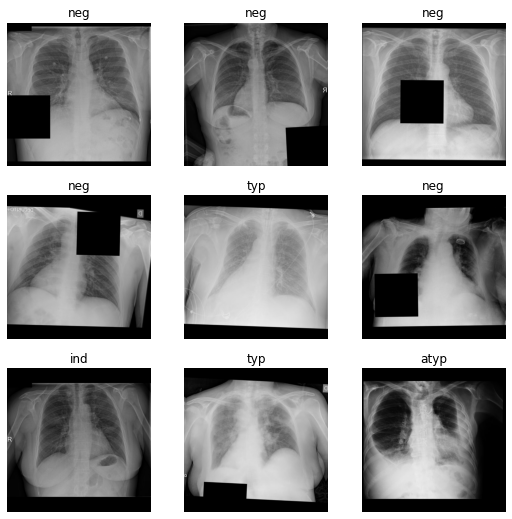

In [78]:
dls_folds[0].show_batch()

In [79]:
learn_folds = [
    train_class.get_learn(dls=dls, model_name=MODEL_NAME, is_neg=False)
    for dls in dls_folds
]

In [67]:
def _first(l, n):
    if len(l) <= n:
        return l
    return l[:n]

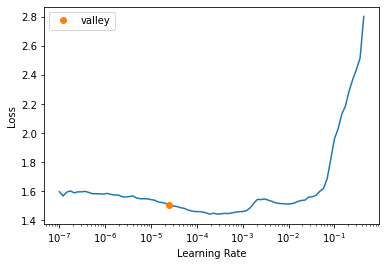

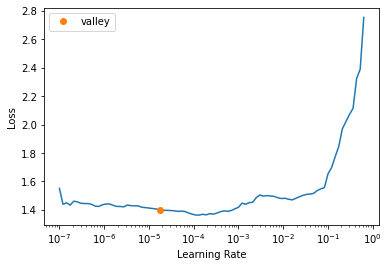

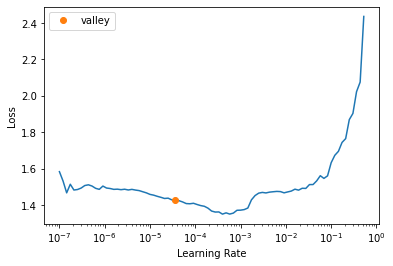

In [68]:
for learn_fold in _first(learn_folds, 3):
    res = learn_fold.lr_find()

In [80]:
for i, learn in enumerate(learn_folds):
    print(f"Training fold {i}")
    learn.fit_one_cycle(10, 3e-4)
    plt.pause(0.001)

Training fold 0


epoch,train_loss,valid_loss,time
0,1.172855,1.096481,00:55
1,1.094863,1.118470,00:54
2,1.077524,1.137290,00:54
3,0.960868,1.074453,00:54
4,0.949413,0.973455,00:54
5,0.934100,0.914911,00:55
6,0.895652,0.952818,00:55
7,0.830894,0.916697,00:54
8,0.767343,0.925826,00:55
9,0.717159,0.927563,00:55


Training fold 1


epoch,train_loss,valid_loss,time
0,1.187485,1.480647,00:54
1,1.122201,1.089810,00:55
2,1.030971,1.166968,00:54
3,0.979434,1.532428,00:54
4,0.944734,0.999721,00:54
5,0.918030,0.992716,00:54
6,0.872004,0.928078,00:54
7,0.813722,0.899595,00:54
8,0.728213,0.897507,00:55
9,0.661164,0.907389,00:55


Training fold 2


epoch,train_loss,valid_loss,time
0,1.188109,1.138633,00:55
1,1.132963,1.080997,00:55
2,1.037086,1.046499,00:54
3,0.982633,1.250674,00:54
4,0.951223,0.959123,00:55
5,0.917404,0.952484,00:54
6,0.872529,0.936090,00:54
7,0.800965,0.915036,00:54
8,0.752944,0.916806,00:54
9,0.691871,0.914722,00:55


Training fold 3


epoch,train_loss,valid_loss,time
0,1.206200,1.027525,00:54
1,1.128352,1.176323,00:55
2,1.038989,0.974246,00:54
3,1.014035,0.913185,00:54
4,0.957376,0.933115,00:55
5,0.936046,0.903919,00:54
6,0.905260,0.913255,00:55
7,0.831370,0.869757,00:55
8,0.770584,0.859848,00:55
9,0.715368,0.861378,00:55


Training fold 4


epoch,train_loss,valid_loss,time
0,1.188666,1.215628,00:55
1,1.137348,1.134671,00:55
2,1.033759,1.034926,00:55
3,1.005306,1.049308,00:55
4,0.952485,0.947342,00:54
5,0.899098,0.920944,00:54
6,0.869700,0.886368,00:55
7,0.818734,0.912607,00:55
8,0.732966,0.899120,00:54
9,0.685685,0.902911,00:55


In [81]:
train_class.save_learn_folds(
    learn_folds=learn_folds, model_name=MODEL_NAME, is_neg=False
)

In [91]:
preds, targs = train_class.predict_and_save_folds(
    learn_folds=learn_folds, 
    model_name=MODEL_NAME, 
    n_tta=6,
    is_neg=False,
)

In [92]:
print(train_class.preds_map(preds, targs))

0.36027863016655964


In [84]:
# Analyze errors

In [86]:
train_class.analyze_accuracy_by_category(
    dls=dls_folds[0], preds=preds, targs=targs
)

,mean,count,lab
act,,,
0,0.229167,96,atyp
1,0.078704,216,ind
2,0.780702,342,neg
3,0.834739,593,typ


In [ ]:
interp = ClassificationInterpretation.from_learner(learn_folds[0])

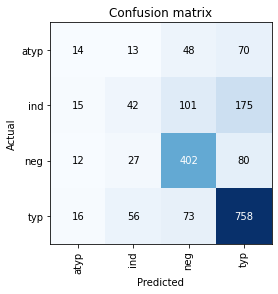

In [518]:
interp.plot_confusion_matrix()

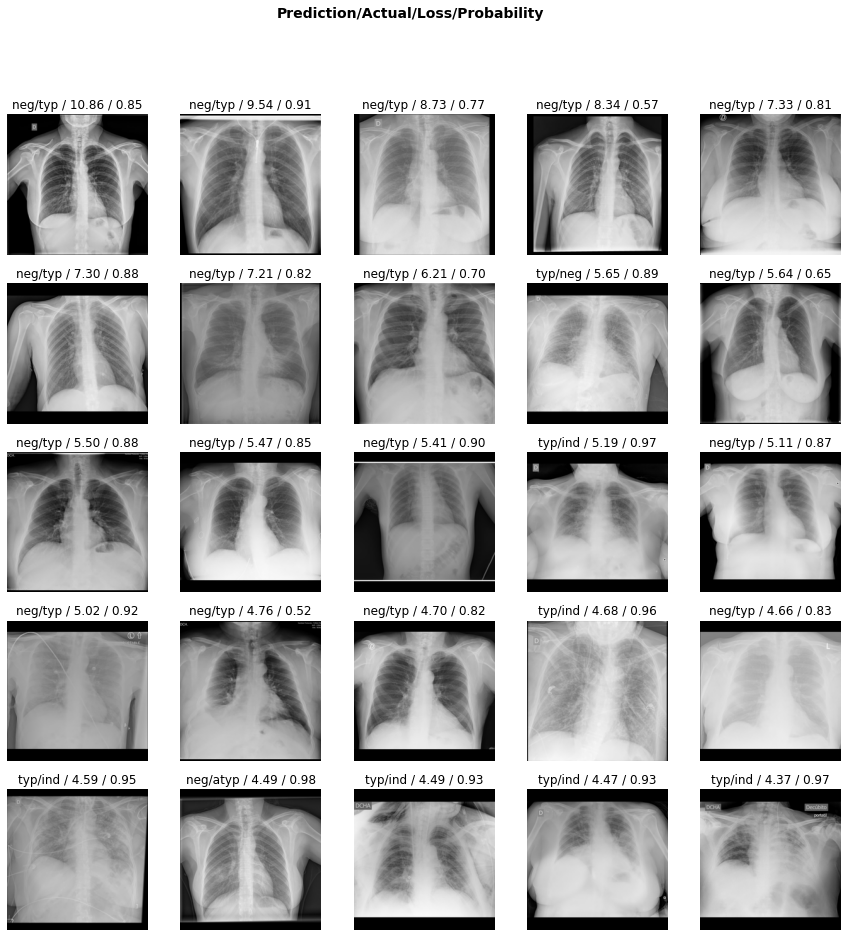

In [517]:
interp.plot_top_losses(25, nrows=5)
# I don't really see any patterns

In [32]:
# LEARN NEG #

In [93]:
NEG_IMAGE_PATH = "jpg640_5fold"
NEG_NUM_FOLDS = 5
NEG_IMAGE_SIZE = 640
NEG_MODEL_NAME = "resnet34"

In [94]:
neg_dls_folds = [
    train_class.get_dls(
        image_path=NEG_IMAGE_PATH, 
        img_size=NEG_IMAGE_SIZE, 
        is_neg=True, 
        fold_valid=fold,
    )
    for fold in range(NEG_NUM_FOLDS)
]
len(neg_dls_folds[0].train.items), len(neg_dls_folds[0].valid.items), neg_dls_folds[0].vocab, neg_dls_folds[0].one_batch()[0].shape

(4996, 1247, ['negative', 'positive'], torch.Size([32, 3, 640, 640]))

In [95]:
neg_learn_folds = [
    train_class.get_learn(dls=neg_dls, model_name=NEG_MODEL_NAME, is_neg=True)
    for neg_dls in neg_dls_folds
]

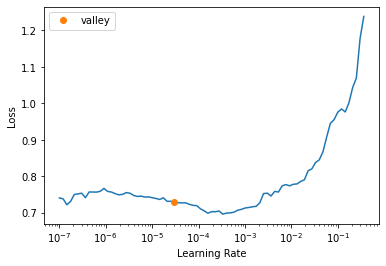

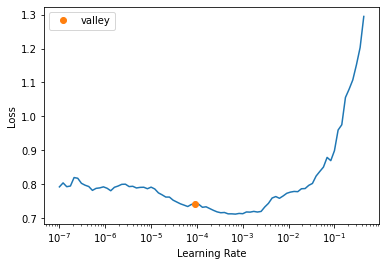

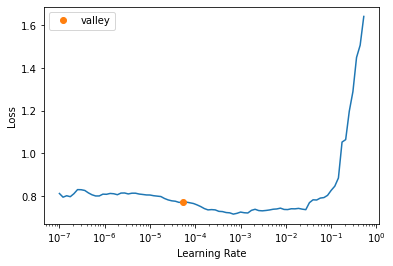

In [75]:
for neg_learn in _first(neg_learn_folds, 3):
    res = neg_learn.lr_find()

In [96]:
for neg_learn in neg_learn_folds:
    neg_learn.fit_one_cycle(10, 3e-4)

epoch,train_loss,valid_loss,time
0,0.577915,0.617354,00:54
1,0.546052,0.552907,00:54
2,0.490191,0.588299,00:55
3,0.415819,0.438216,00:55
4,0.402110,0.547904,00:54
5,0.367170,0.414443,00:55
6,0.349159,0.408517,00:55
7,0.314881,0.365376,00:55
8,0.288469,0.371911,00:55
9,0.277701,0.376469,00:54


epoch,train_loss,valid_loss,time
0,0.596692,0.715831,00:55
1,0.554527,0.876254,00:55
2,0.459048,0.409180,00:55
3,0.440094,0.586134,00:54
4,0.401604,0.384646,00:55
5,0.372745,0.594240,00:55
6,0.348106,0.363097,00:55
7,0.337090,0.340762,00:55
8,0.297267,0.343764,00:55
9,0.288037,0.339512,00:54


epoch,train_loss,valid_loss,time
0,0.583990,0.467896,00:54
1,0.532089,0.552293,00:54
2,0.464821,0.416434,00:55
3,0.436270,0.568191,00:55
4,0.407984,0.416782,00:55
5,0.387282,0.428908,00:55
6,0.348108,0.364341,00:55
7,0.325544,0.398063,00:55
8,0.287401,0.389902,00:55
9,0.271936,0.378805,00:55


epoch,train_loss,valid_loss,time
0,0.601376,0.891550,00:54
1,0.560675,0.595767,00:55
2,0.486001,0.402174,00:55
3,0.442802,0.359845,00:55
4,0.425501,0.408531,00:55
5,0.398780,0.369291,00:54
6,0.363315,0.369516,00:55
7,0.339669,0.323922,00:54
8,0.320553,0.316340,00:55
9,0.307561,0.314067,00:54


epoch,train_loss,valid_loss,time
0,0.574892,0.450964,00:55
1,0.549808,0.716937,00:54
2,0.476643,0.438268,00:55
3,0.437413,0.395314,00:55
4,0.409879,0.449518,00:54
5,0.393548,0.387528,00:55
6,0.363407,0.370140,00:55
7,0.334044,0.354308,00:55
8,0.308626,0.352453,00:55
9,0.281926,0.344704,00:55


In [97]:
train_class.save_learn_folds(
    learn_folds=neg_learn_folds, model_name=NEG_MODEL_NAME, is_neg=True
)

In [98]:
neg_preds, neg_targs = train_class.predict_and_save_folds(
    learn_folds=neg_learn_folds, 
    model_name="resnet18", 
    n_tta=6, 
    is_neg=True,
)

In [99]:
print(train_class.preds_map(neg_preds, neg_targs))
print(train_class.preds_loss(neg_preds, neg_targs))

0.5685934902823225
0.34248122572898865


In [29]:
train_class.analyze_accuracy_by_category(
    dls=neg_dls_folds[0], preds=neg_preds, targs=neg_targs
)

,mean,count,lab
act,,,
0,0.666277,1711,negative
1,0.901589,4532,positive


In [519]:
neg_interp = ClassificationInterpretation.from_learner(neg_learn_folds[0])

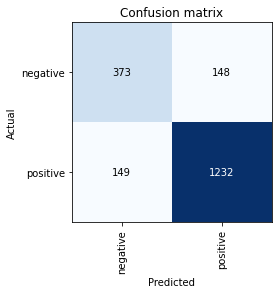

In [520]:
neg_interp.plot_confusion_matrix()

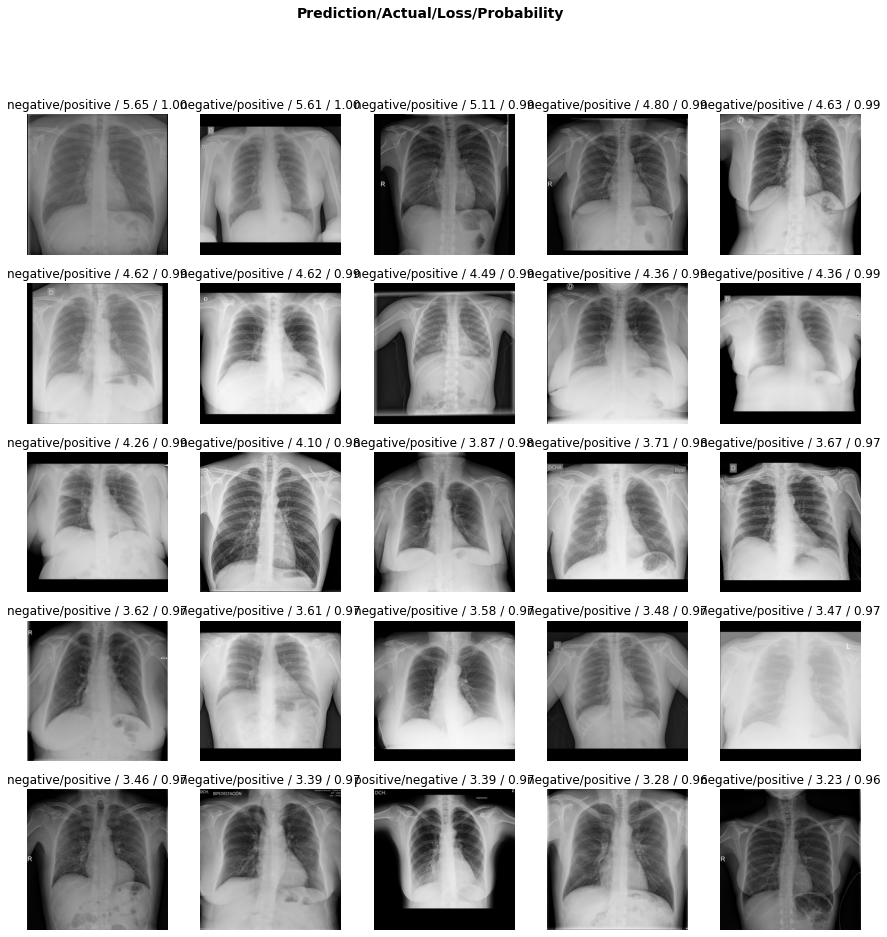

In [521]:
neg_interp.plot_top_losses(25, nrows=5)
# Dang, those confidences are really freaking high